In [1]:
%pylab notebook

Populating the interactive namespace from numpy and matplotlib


In [50]:
import tweepy
from tweepy import OAuthHandler
import pickle as p
import re
import json
from collections import defaultdict
import random
from numpy import arange, where, isin
from bs4 import BeautifulSoup
import requests
from scipy.optimize import curve_fit
from random import uniform

# Collect Trump's Tweets 

In [11]:
twitter_keys=p.load(open('tk.pkl','rb'))

In [12]:

 
auth = OAuthHandler(twitter_keys['consumer_key'], twitter_keys['consumer_secret'])
auth.set_access_token(twitter_keys['access_token'], twitter_keys['access_secret'])
 
api = tweepy.API(auth)

In [13]:
def limit_handled(cursor):
    while True:
        try:
            yield cursor.next()
        except tweepy.RateLimitError:
            time.sleep(15 * 60)
            

In [14]:
hold=[]
with open('test.txt','w') as f:
    json.dump([], f)
for i,status in enumerate(limit_handled(tweepy.Cursor(api.user_timeline,'realDonaldTrump').items(1000))):
    hold.append(status._json)
    if i%100==0:
        with open('test.txt','r') as f:
            a=json.load(f)+hold
        with open('test.txt','w') as f:
            json.dump(a, f)
        hold=[]

In [3]:
trump_tweets=json.load(open('test.txt','r'))

# Trump Tweet Times 

In [4]:
def convert_time(t):
    return int(t[:2])+int(t[3:5])/60+int(t[6:8])/3600
    

def tweet_times(tweets):
    times=[]
    for t in tweets:
        created_at = t['created_at']
        col_loc=where([v==':' for v in created_at])[0][0]
        times.append(convert_time(created_at[col_loc-2:col_loc+6]))
    return array(times)

In [5]:
times=tweet_times(trump_tweets)-7
for i,t in enumerate(times):
    if t<0:
        times[i]+=24
        

<IPython.core.display.Javascript object>


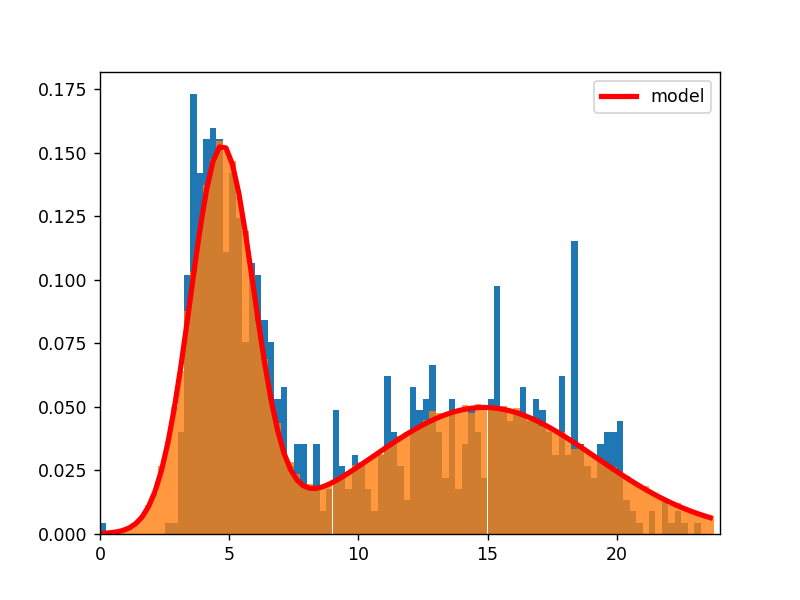

[  4.71634945   1.22445296   0.45938613  14.85825005   4.33064769] 
 [ 0.08078926  0.08333872  0.02925978  0.46831699  0.47928904]


In [47]:
counts,bounds,_=hist(times,bins=arange(0,24,.25),normed=True)
bin_c=(bounds[1:]+bounds[:-1])/2

def gauss(x,mu,sigma):
    return exp(-(x-mu)**2/2/sigma**2)/sqrt(2*pi*sigma**2)

def bimodal(x,mu1,sigma1,w1,mu2,sigma2):
    return w1*gauss(x,mu1,sigma1)+(1-w1)*gauss(x,mu2,sigma2)

expected=(5,1,.1,15,5)
params,cov=curve_fit(bimodal,bin_c,counts,expected)
sigma=sqrt(diag(cov))
plot(bin_c,bimodal(bin_c,*params),color='red',lw=3,label='model')

g1 = normal(params[0],params[1],int(round(params[2]*len(times)*100)))
g2 = normal(params[3],params[4],int(round((1-params[2])*len(times)*100)))
gg=concatenate((g1,g2))
counts1,bounds1,_=hist(gg,bins=arange(0,24,.25),alpha=.8,normed=True)

xlim(0,24)
legend()
print(params,'\n',sigma)  

#xlim(0,24)

# Generate Times 

In [90]:
time=25
while (time<0 or time>24):
    if uniform(0,1) >= params[2]:
        time = normal(params[3],params[4])
    else:
        time = normal(params[0],params[1])
    time+=7
    if time>24: time-=24
print(time)

21.398698656337316


# Filter tweets into strings 

In [9]:
def retweet_filter(tweet):
    

SyntaxError: unexpected EOF while parsing (<ipython-input-9-bdde08e767c3>, line 2)

In [13]:
def drop_links(tweet_words):
    try:
        cutoff=where([x=='https' for x in tweet_words])[0][0]
        return tweet_words[:cutoff]
    except IndexError:
        return tweet_words

In [14]:
def tweets_to_list(tweets):
    tweet_words=[]
    for tweet in tweets:
        if tweet['text'][:2]!='RT':
            tweet_words.extend(drop_links(re.findall(r"[\w']+|[.,!?;]",tweet['text'])))
    return tweet_words

In [15]:
trump_words=tweets_to_list(trump_tweets)


# Generate New Tweets 

In [80]:
def generate_using_ngrams(n,words):
    '''
    Generate a sentence using the ngrams method. 
    
    Params:
    n: Words is broken into seqences of length n, n-1 words are then used to predict the next word.
    words: A list of words that generated sentences will be based on.
    '''
    
    if not n>1:raise ValueError("n must be at least 2")
        
    ngrams=zip(*[words[i:] for i in arange(n)])
    transitions=defaultdict(list)
    starts=[]
    
    for ngram in ngrams:
        if ngram[0] in ['.','!','?']:
            starts.append(ngram[1:-1])
        transitions[ngram[:-1]].append(ngram[-1])
    
    
    current= random.choice(starts)
    prev='.'
    result=[*current]

    while True:
        next_word_candidates=transitions[(prev,*current)]
        next_word = random.choice(next_word_candidates)
        prev, current = current[0], current[1:]+(next_word,)
        result.append(current[-1])
        if current[-1] in ['.','!','?']: return ' '.join(result)

SyntaxError: can use starred expression only as assignment target (<ipython-input-80-191718b5eeed>, line 24)

In [78]:
generate_using_ngrams(4,trump_words)

[('While', 'not')]


IndexError: Cannot choose from an empty sequence

In [23]:
def generate_using_nxmgrams(n,m,words):
    '''
    Generate a sentence using the ngrams method. 
    
    Params:
    n: Words is broken into seqences of length n, n-1 words are then used to predict the next word.
    words: A list of words that generated sentences will be based on.
    '''
    
    if not n>1:raise ValueError("n must be at least 2")
        
    nxmgrams=zip(*[words[i:] for i in arange(n+m)])
    transitions=defaultdict(list)
    starts=[]
    
    for nxmgram in nxmgrams:
        if nxmgram[0] in ['.','!','?']:
            starts.append(nxmgram[1:-m])
        transitions[nxmgram[:-m]].append(nxmgram[-m:])
    
    current= random.choice(starts)
    prev='.'
    result=[*current]
    while True:
        next_candidates=transitions[(prev,*current)]
        next = random.choice(next_candidates)
        prev = current[m-n]
        if n-1-m==0:
            current = (*next,)
        else:
            current =  current[m+1-n:]+(*next,)
        for c in current[-m:]: result.append(c)
        if current[-1] in ['.','!','?']: return ' '.join(result)

SyntaxError: can use starred expression only as assignment target (<ipython-input-23-489fa66c66c7>, line 23)

In [21]:
generate_using_nxmgrams(3,2,trump_words)

'He is strong on Border amp ; Wall , the military , tax cuts amp ; reform .'

# Scrape Fox News for Headlines 

In [17]:
url="http://www.foxnews.com"
html=requests.get(url).text
soup=BeautifulSoup(html,'html5lib')

In [18]:
stories=soup.find_all('h2',{'class':['title']})

In [21]:
headlines=[story.a.contents[0] for story in stories if 'video' not in story.a.get('href')]


In [22]:
headlines

['At least 10 dead as tens of thousands race to escape Northern California flames',
 'ESPN suspends anti-Trump anchor for attacking president, Dallas Cowboys',
 "Cops say hotel security guard took Vegas shooter's bullet 6 minutes before attack",
 'Giant Trump pin cushion turns heads at art competition',
 "Backlash over 'sexual identity' test in sixth-grade class",
 "Texas Tech campus locked down, 'shooter at large'",
 "Melania bashes Trump's ex-wife Ivana for calling herself first lady",
 'North Korea could use Oct. 10 holiday as excuse to provoke US, experts say',
 'Twitter shuts down GOP congresswoman’s campaign video over anti-abortion line',
 'Ex-con stands trial in brutal burning murder of former Mississippi cheerleader, 19',
 'University of Pittsburgh student found dead in homicide at off-campus home',
 'Lives lost in Mexico quake could have been saved, engineers say',
 "Groveling Harvey Weinstein sends 'desperate' email to Hollywood elite before getting fired, report says",
 'Jo